# Sequence Embeddings dos Hinos da ICM
Este notebook explora técnicas de sequence embeddings para representar os textos completos dos hinos da coletânea principal da Igreja Cristã Maranata.

O objetivo é aplicar modelos de embeddings de sentenças, calcular similaridade, realizar agrupamentos, buscar hinos por texto e extrair tópicos com BERTopic.

---
**Conteúdo do notebook:**
- Carregamento do modelo SentenceTransformer e dos dados tratados
- Geração de embeddings para cada hino
- Cálculo de similaridade entre hinos
- Visualização de matrizes de similaridade
- Redução de dimensionalidade (t-SNE, UMAP)
- Agrupamento de hinos por KMeans
- Busca de hinos por texto
- Extração de tópicos com BERTopic
- Visualização dos agrupamentos e tópicos
- Salvamento dos resultados para uso futuro

Este material é público e pode ser compartilhado para fins de pesquisa, estudo ou divulgação cultural.

# Parte 4 - Sequence embeddings

---

**A seguir:** Carregamento do modelo SentenceTransformer para geração de embeddings de sentenças dos hinos.

In [1]:
from sentence_transformers import SentenceTransformer

# Diversas opções de modelos:
# model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
# model = SentenceTransformer("neuralmind/bert-base-portuguese-cased")
model = SentenceTransformer(
    "rufimelo/Legal-BERTimbau-sts-base-ma-v2"
)  # português brasileiro
# model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")  # mais leve e eficiente

c:\ProgramData\anaconda3\envs\hinos-db\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Invalid model-index. Not loading eval results into CardData.


---

**A seguir:** Carregamento dos dados dos hinos já enriquecidos com embeddings anteriores, prontos para análise de sentenças.

In [2]:
import pandas as pd

hinos_analise: pd.DataFrame = pd.read_pickle(
    "..\\assets\\hinos_analise_word_embeddings.pkl"
)

---

**A seguir:** Geração dos embeddings de sentenças para cada hino, representando o texto completo em um vetor denso.

In [3]:
import numpy as np

# cria embeddings diretamente para cada hino (texto inteiro)
embeddings = model.encode(hinos_analise["texto_limpo"].tolist(), show_progress_bar=True)
X_sent = np.array(embeddings)
hinos_analise["sent_embeddings"] = list(X_sent)

print(X_sent.shape)

Batches: 100%|██████████| 25/25 [14:05<00:00, 33.81s/it]


(795, 768)


---

**A seguir:** Cálculo da similaridade entre hinos usando os embeddings de sentenças, identificação dos hinos mais semelhantes ao hino de referência.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X_sent)

# hinos mais semelhantes ao hino 443
similarities = list(enumerate(similarity_matrix[443]))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

print("Mais parecidos com o hino 443:")
for idx, score in similarities[1:6]:
    print(f"Hino {idx}: {hinos_analise['nome'].iloc[idx]} → similaridade {score:.3f}")

Mais parecidos com o hino 443:
Hino 233: VOU GUIAR-TE A UMA RICA FONTE → similaridade 0.841
Hino 517: JÁ NÃO TARDA O AMANHECER → similaridade 0.831
Hino 539: JUNTO AO TRONO DE DEUS, PREPARADO → similaridade 0.830
Hino 709: RESPLANDECE, Ó JERUSALÉM → similaridade 0.828
Hino 623: EU QUERO CANTAR DE GOZO E DE PAZ → similaridade 0.819


---

**A seguir:** Visualização da matriz de similaridade entre hinos utilizando heatmap para facilitar a análise dos padrões de similaridade.

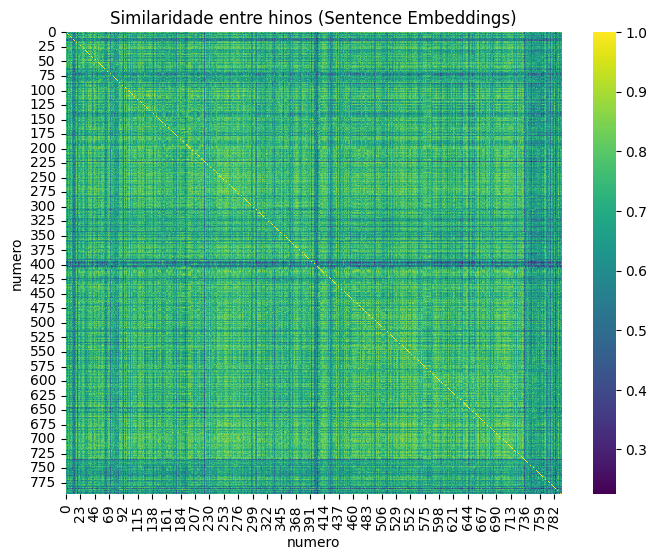

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

similarity_matrix_df = pd.DataFrame(
    similarity_matrix, index=hinos_analise.index, columns=hinos_analise.index
)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix_df, cmap="viridis", annot=False, cbar=True)
plt.title("Similaridade entre hinos (Sentence Embeddings)")
plt.show()

---

**A seguir:** Redução de dimensionalidade dos embeddings dos hinos utilizando t-SNE e UMAP para visualização e agrupamento.

c:\ProgramData\anaconda3\envs\hinos-db\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


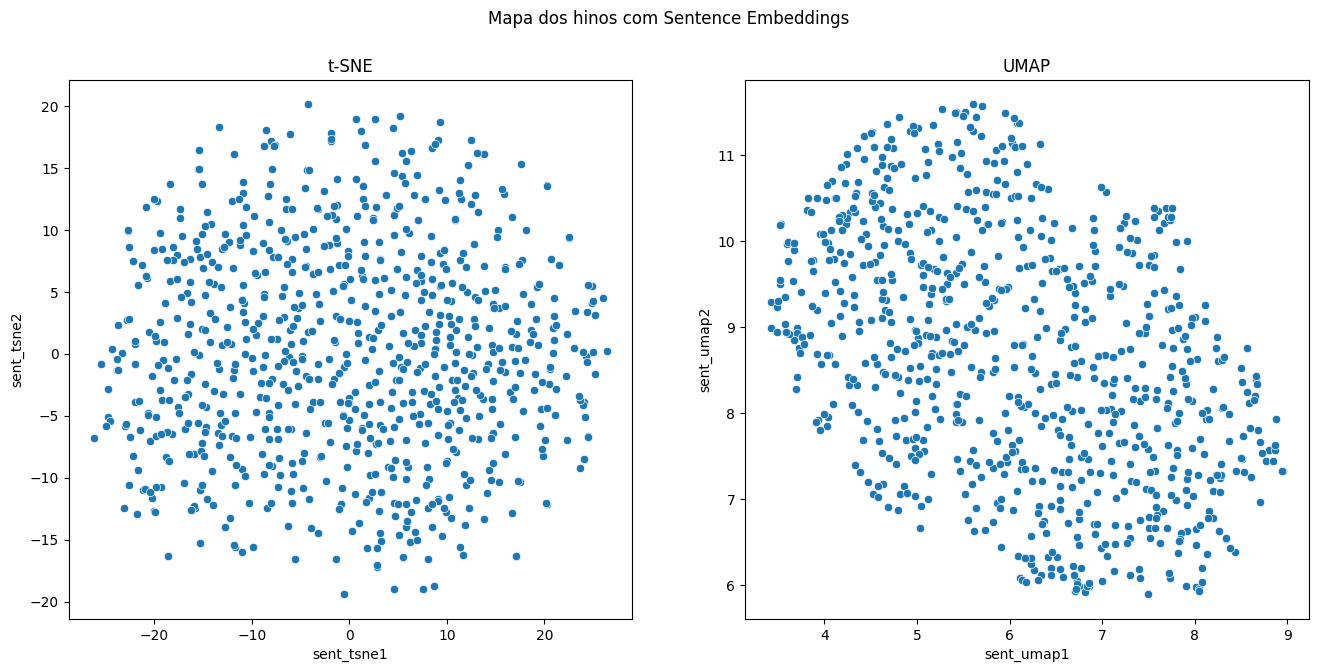

In [6]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,  # 2D
    perplexity=30,
    random_state=42,
)
X_tsne = tsne.fit_transform(X_sent)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_sent)

hinos_analise["sent_tsne1"] = X_tsne[:, 0]
hinos_analise["sent_tsne2"] = X_tsne[:, 1]

hinos_analise["sent_umap1"] = X_umap[:, 0]
hinos_analise["sent_umap2"] = X_umap[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.scatterplot(data=hinos_analise, x="sent_tsne1", y="sent_tsne2", ax=ax[0])
ax[0].set_title("t-SNE")
sns.scatterplot(data=hinos_analise, x="sent_umap1", y="sent_umap2", ax=ax[1])
ax[1].set_title("UMAP")
plt.suptitle("Mapa dos hinos com Sentence Embeddings")
plt.show()

---

**A seguir:** Análise de agrupamento dos hinos utilizando KMeans, avaliação do número ideal de clusters com o coeficiente de Silhouette.

k = 2, silhouette = 0.4419
k = 3, silhouette = 0.3400
k = 4, silhouette = 0.3865
k = 5, silhouette = 0.3719
k = 6, silhouette = 0.3513
k = 7, silhouette = 0.3565
k = 8, silhouette = 0.3716
k = 9, silhouette = 0.3773
k = 10, silhouette = 0.3611
k = 11, silhouette = 0.3519


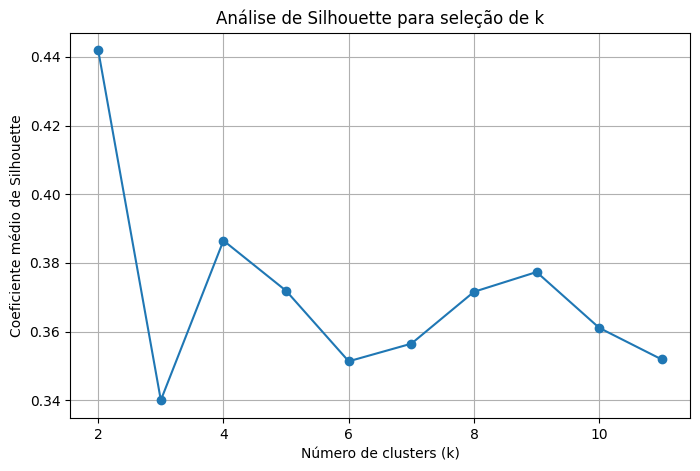

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


range_n_clusters = range(2, 12)
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, silhouette = {score:.4f}")

# Visualiza o resultado
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker="o")
plt.title("Análise de Silhouette para seleção de k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente médio de Silhouette")
plt.grid(True)
plt.show()

---

**A seguir:** Visualização dos agrupamentos dos hinos por embeddings reduzidos, utilizando scatterplot para UMAP e clusters do KMeans.

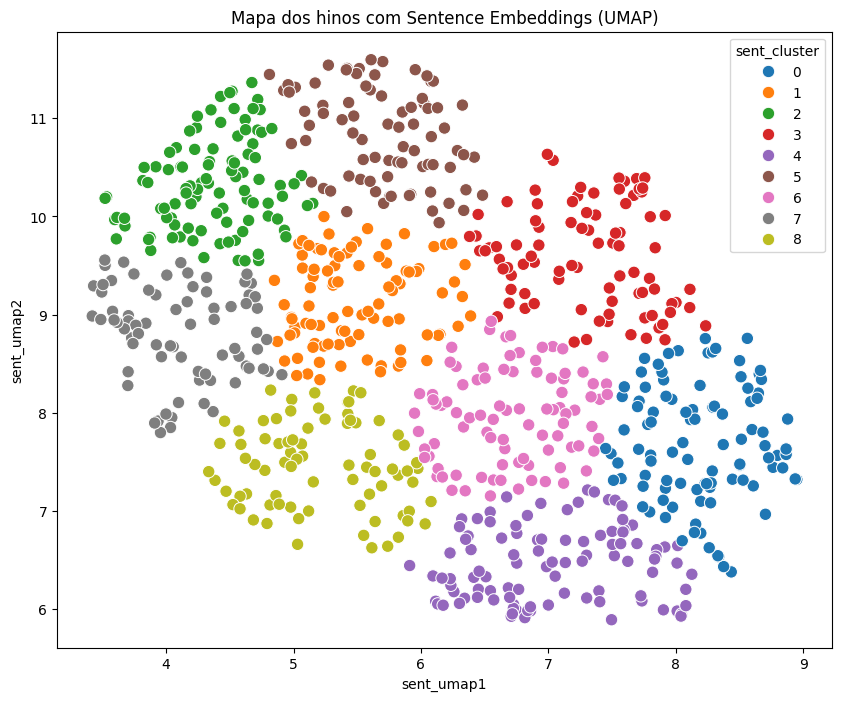

In [12]:
kmeans = KMeans(n_clusters=9, random_state=42)
hinos_analise["sent_cluster"] = kmeans.fit_predict(X_umap)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=hinos_analise,
    x="sent_umap1",
    y="sent_umap2",
    hue="sent_cluster",
    palette="tab10",
    s=80,
)
plt.title("Mapa dos hinos com Sentence Embeddings (UMAP)")
plt.show()

---

**A seguir:** Análise dos termos mais frequentes em cada cluster e visualização da distribuição dos hinos por cluster.

In [13]:
from collections import Counter

for c in sorted(hinos_analise["sent_cluster"].unique()):
    cluster_tokens = hinos_analise.loc[
        hinos_analise["sent_cluster"] == c, "tokens_no_stops"
    ].sum()
    top_terms = Counter(cluster_tokens).most_common(10)
    print(f"\nCluster {c}:")
    print([t for t, _ in top_terms])
    print(hinos_analise.loc[hinos_analise["sent_cluster"] == c, "nome"][:5])

print(hinos_analise["sent_cluster"].value_counts().sort_index())


Cluster 0:
['senhor', 'amor', 'quero', 'deus', 'vem', 'jesus', 'alma', 'sempre', 'amo', 'pai']
numero
1     O SANGUE DE JESUS TEM PODER
3                      CLAMO A TI
8            PELO SANGUE DE JESUS
9           SENHOR, ME CHEGO A TI
12            HÁ VITÓRIA PARA MIM
Name: nome, dtype: object

Cluster 1:
['jesus', 'deus', 'senhor', 'cristo', 'amor', 'vida', 'paz', 'coração', 'vem', 'céu']
numero
4                              QUANDO TE PROSTRARES
10                            VAMOS LAVAR AS VESTES
67                                     TOCA PELA FÉ
79     DEUS ESTÁ PRESENTE ENTRE  PECADORES COMO NÓS
111                     O POVO QUE ANDAVA EM TREVAS
Name: nome, dtype: object

Cluster 2:
['jesus', 'glória', 'senhor', 'deus', 'vem', 'aleluia', 'santo', 'rei', 'cristo', 'céu']
numero
2     O SANGUE DE JESUS TEM PODER PARA SALVAR
15                         CLAMAREI, CLAMAREI
16                         SE ANDARMOS NA LUZ
19                             TEU POVO CLAMA
20             O T

---

**A seguir:** Busca de hinos por similaridade textual, utilizando embeddings para encontrar os hinos mais próximos de uma consulta em linguagem natural.

In [14]:
query = "a palavra é alimento para a alma"
query_vec = model.encode([query])

scores = cosine_similarity(query_vec, X_sent)[0]
top_idx = np.argsort(scores)[::-1][:10]

print("Top hinos para a busca:")
for i in top_idx:
    print(f"Hino {i}: {hinos_analise['nome'].iloc[i]} → score {scores[i]:.3f}")

Top hinos para a busca:
Hino 429: ÉS O PÃO DA VIDA → score 0.400
Hino 647: SANTO, SANTO, SANTO É O SENHOR → score 0.394
Hino 734: A VIDA DE MINH’ALMA → score 0.385
Hino 15: CLAMAREI, CLAMAREI → score 0.376
Hino 158: JESUS, O LÍRIO DOS VALES → score 0.372
Hino 785: ESTOU CONFIANDO → score 0.367
Hino 241: MEU AMADO FILHO → score 0.364
Hino 82: CADA INSTANTE → score 0.360
Hino 612: SANTO, SANTO, SANTO,  Ó DEUS DE GLÓRIA E PODER → score 0.360
Hino 216: SOMOS TEU POVO → score 0.359


---

**A seguir:** Extração de tópicos dos hinos utilizando BERTopic, atribuição dos tópicos aos hinos e visualização da distribuição dos tópicos.

# Tópicos

---

**A seguir:** Visualização dos agrupamentos dos hinos por tópicos extraídos com BERTopic, utilizando scatterplot para UMAP.

In [15]:
from bertopic import BERTopic

# Criar o modelo BERTopic
topic_model = BERTopic(embedding_model=model)

# Treinar modelo
topics, probs = topic_model.fit_transform(hinos_analise["texto_limpo"])

# Associar tópicos ao DataFrame
hinos_analise["BERT_topic"] = topics

---

**A seguir:** Visualização dos agrupamentos dos hinos por tópicos em diferentes projeções (UMAP), utilizando BERTopic.

In [16]:
print("\nDistribuição de tópicos por hino:")
print(hinos_analise["BERT_topic"].value_counts())

# Mostrar os tópicos descobertos
print("\nTópicos extraídos:")
for topic_num in set(topics):
    if (
        topic_num != -1
    ):  # -1 significa "outlier" (documento não encaixou em nenhum cluster)
        palavras = topic_model.get_topic(topic_num)
        print(f"Tópico {topic_num}:")
        print([word for word, _ in palavras])


Distribuição de tópicos por hino:
BERT_topic
-1    414
 0    121
 1     72
 2     44
 3     36
 4     24
 5     20
 6     19
 7     18
 8     15
 9     12
Name: count, dtype: int64

Tópicos extraídos:
Tópico 0:
['amor', 'me', 'meu', 'eu', 'que', 'em', 'senhor', 'mim', 'quero', 'teu']
Tópico 1:
['glória', 'de', 'jesus', 'que', 'vem', 'os', 'com', 'senhor', 'santo', 'rei']
Tópico 2:
['eu', 'que', 'jesus', 'cristo', 'céu', 'de', 'me', 'meu', 'com', 'dia']
Tópico 3:
['que', 'no', 'ele', 'de', 'jesus', 'deus', 'na', 'com', 'do', 'se']
Tópico 4:
['senhor', 'teu', 'nos', 'nosso', 'nós', 'nossa', 'tua', 'vidas', 'louvor', 'te']
Tópico 5:
['ti', 'mim', 'tu', 'és', 'minha', 'meu', 'de', 'senhor', 'em', 'vem']
Tópico 6:
['eu', 'de', 'meu', 'hei', 'ao', 'do', 'que', 'ver', 'me', 'terra']
Tópico 7:
['tais', 'que', 'dos', 'sossegai', 'um', 'nos', 'cristo', 'senhor', 'jesus', 'deixa']
Tópico 8:
['sangue', 'teu', 'mim', 'estendeu', 'me', 'para', 'mão', 'em', 'sem', 'senhor']
Tópico 9:
['louvai', 'sen

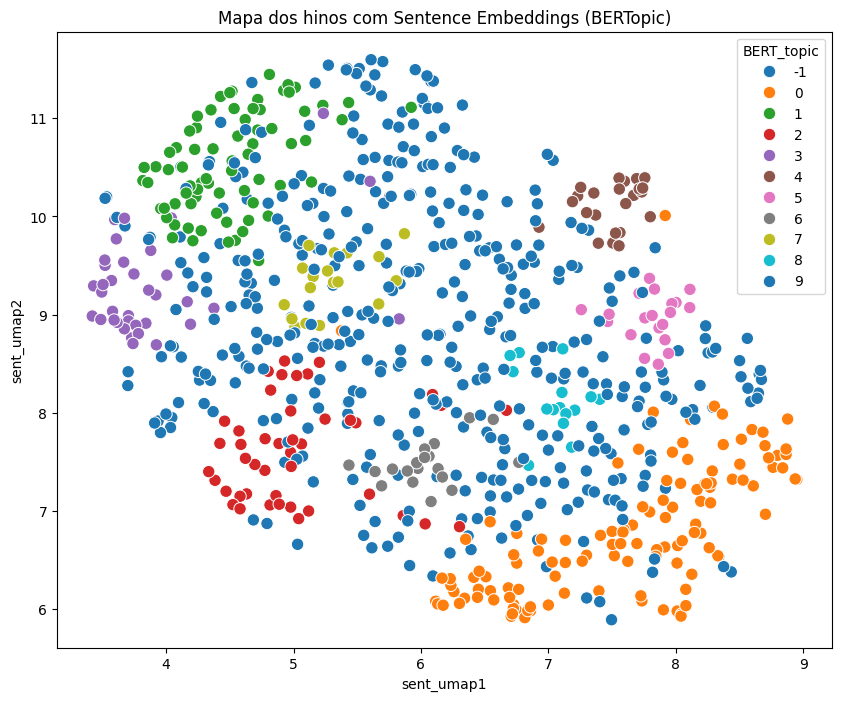

In [17]:
# número de clusters (experimente, ex.: 4 ou 6)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=hinos_analise,
    x="sent_umap1",
    y="sent_umap2",
    hue="BERT_topic",
    palette="tab10",
    s=80,
)
plt.title("Mapa dos hinos com Sentence Embeddings (BERTopic)")
plt.show()

---

**A seguir:** Salvamento dos resultados e informações enriquecidas dos hinos para uso em análises futuras.

# Salvamento de informações novas

---

**Fim do notebook:** Finalização do processamento, com os dados prontos para exportação e uso em outras análises ou aplicações.

In [18]:
hinos_analise.to_pickle("..\\assets\\hinos_analise_embeddings_complete.pkl")

In [19]:
similarity_matrix_df.to_pickle("..\\assets\\similarity_matrix_sentence_embeddings.pkl")